# Procesamiento el Informe de Proyección Semanal de Demanda de Gas Emitido por ENARGAS
Fuente: https://www.enargas.gob.ar/secciones/transporte-y-distribucion/despacho-diario-proyeccion-semanal.php

Fuente en Excel: mail de TGS

In [2]:
#******************************************************************************************
#* Procesamiento del Informe de Proyeccción Semanal de Demanda de Gas Emitido por ENARGAS
#******************************************************************************************
## Notebook original 
## C:\Users\COLMO\OneDrive - Pampa Energia\Documents\Pampa-NB531258\2019 - DOF\19-Comercial\COM_db\python\COM_proy_semanal_demanda_gas.ipynb
#---------------------------------------------------------------------------
# 0- Configuración del Archivo de Logging
#---------------------------------------------------------------------------
import sys, traceback
# Parámetros: 
# argv[0] es el nombre del script
# argv[1] path del log
# argv[2] path de los archivos de datos
# argv[3] nombre del servidor de SQL de la base de datos kindleys
# argv[4] nombre de la base de datos SQL de kindleys
############ IMPORTANTE: habilitar las siguientes 2 líneas cuando se ejecuta el script
#if len(sys.argv) < 5:
#    raise OSError('Argument Missing. # of Arguments provided: ' + str(len(sys.argv)))
#server = 'NBPC1M7MAL\SQLEXPRESS'
server = 'WK517338\SQLEXPRESS' # argv[3]
#server = 'DESKTOP-0FBKFFQ\SQLEXPRESS'
database = 'comercial' # argv[4]

# Ubicación donde se encuentra el log del script
#path = r'\\..\proyectos\99-Gobernanza de Datos\017_comercial\COM_db\logs' # sys.argv[1]
#data_path = r'\\..\proyectos\99-Gobernanza de Datos\017_comercial\COM_db\data\PS' # sys.argv[2]
path = r'C:\data\enargas' # sys.argv[1]
data_path = r'C:\data\enargas\PS' # sys.argv[2]
# Para que se escriba en el archivo log, colocar write_log en True
write_log = False
if write_log:
    import logging
    logging.basicConfig(filename=path + '\proy_dem_sem_gas.log', format='%(asctime)s %(levelname)s:%(message)s', 
                        datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.WARNING)
    #                    , level=logging.WARNING, encoding='utf-8')
    logging.warning('***************************** Inicio Ejecución')

In [4]:
try:
    # Importando librerías necesarias:
    import os
    import os.path
    #from os import listdir, getcwd
    #from os.path import isfile, join
    
    import numpy as np
    import pandas as pd
    import math

    from datetime import datetime, timedelta
    import warnings
    warnings.filterwarnings("ignore", category=Warning)
    pd.options.mode.chained_assignment = None
   
    # Librería para interactuar con bases de datos SQL
    import pyodbc

    import re
    import string

    # Librerías para web scrapping
    #import the library used to query a website
    #import urllib.request

    #import the Beautiful soup functions to parse the data returned from the website
    #from bs4 import BeautifulSoup
    
    import tabula
    #!python -m pip install --upgrade pymupdf
    #https://pymupdf.readthedocs.io/en/latest/installation.html
    # https://stackoverflow.com/questions/47497309/find-text-position-in-pdf-file
    import fitz
    
    from babel.dates import get_day_names, get_month_names
    # get_day_names('short', locale='es')[1], get_day_names('abbreviated', locale='es')[1], 
    # get_day_names('narrow', locale='es')[1], get_day_names('wide', locale='es')[1]
    # # Esta librería tiene varias funciones de hash. Todas devuelven 32 caractereso más, sha1 y md5 (esta devuelve menos caracteres)
    # toman un valor como parámetro y devuelven el mismo hash cuando se les pasa el mismo parámetro
    # Voy a utilizar hashlib.md5(str.encode(my_str)).hexdigest()[:8] tomando los primeros 8 caracteres
    #import hashlib
    
    if 'WK517338' in server:
        user = 'pampa_adm'
        pwd = 'Pampa_aDm'
    else:
        # Librería para obtener el usuario que está ejecutando el script
        import getpass
        user=getpass.getuser()

except Exception as err:
    formatted_lines = traceback.format_exc().splitlines()
    txt = formatted_lines[1] + '\n' + formatted_lines[-1]
    if write_log:
        logging.error('Error Loading packages' + '\n' + txt)
        raise OSError('Error Loading packages' + ' ' + txt)
    else:
        print('Error Loading packages', '\n', txt)
if write_log:
    logging.warning('[0] Carga de Packages Ok')

In [5]:
def build_SQL_cnxn(server=None, database=None, string_connection=None):
    cursor = None
    cnxn = None
    if (not server or not database) and not string_connection:
        bool_raise = True
        error_txt = 'Error trying to Build DB connexion: you missed to send server or database name. ' +\
                    ' Server: ' + (server if server else 'Missed. ') +\
                    ' Database: ' + (database if database else 'Missed.') +\
                    ' String Connection: ' + (database if database else 'Missed.')
    else:
        bool_raise = False
        error_txt = ''
        try:
            if not string_connection:
                cnxn = pyodbc.connect(Driver='{ODBC Driver 17 for SQL Server}',
                                      Server=server,
                                      Database=database,
                                      Trusted_Connection='Yes')
            else:
                cnxn = pyodbc.connect(string_connection)
            cursor = cnxn.cursor()
        except pyodbc.OperationalError as err:
            #cnxn.close()
            formatted_lines = traceback.format_exc().splitlines()
            txt = formatted_lines[1] + '\n' + formatted_lines[-1]
            bool_raise = True
            if not server and not database:
                error_txt = 'Error Conecting to DB ' + string_connection +'\n' + txt
            else:
                error_txt = 'Error Conecting to DB ' + server + ' ' + database +'\n' + txt
        except Exception as err:
            formatted_lines = traceback.format_exc().splitlines()
            txt = formatted_lines[1] + '\n' + formatted_lines[-1]
            bool_raise = True
            if not server and not database:
                error_txt = 'Error Conecting to DB ' + string_connection +'\n' + txt
            else:
                error_txt = 'Error Conecting to DB ' + server + ' ' + database +'\n' + txt
    return cnxn, cursor, bool_raise, error_txt

In [6]:
def execute_SQL(server, database, cursor, sql):
    bool_raise = False
    error_txt = ''
    df_ = pd.DataFrame()
    try:
        cursor.execute(sql)
        rows = cursor.fetchall() 
        df_ = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])
    except pyodbc.OperationalError as err:
        #cursor.close()
        formatted_lines = traceback.format_exc().splitlines()
        txt = formatted_lines[1] + '\n' + formatted_lines[-1]
        bool_raise = True
        error_txt = 'SQL Operational Error ' + server + ' ' + database +'\n' + sql + '\n' + txt
    except pyodbc.DataError as err:
        #cursor.close()
        formatted_lines = traceback.format_exc().splitlines()
        txt = formatted_lines[1] + '\n' + formatted_lines[-1]
        bool_raise = True
        error_txt = 'SQL Operational Error ' + server + ' ' + database +'\n' + sql + '\n' + txt
    except pyodbc.ProgrammingError as err:
        #cursor.close()
        formatted_lines = traceback.format_exc().splitlines()
        txt = formatted_lines[1] + '\n' + formatted_lines[-1]
        bool_raise = True
        error_txt = 'SQL Operational Error ' + server + ' ' + database +'\n' + sql + '\n' + txt
    except Exception as err:
        #cursor.close()
        formatted_lines = traceback.format_exc().splitlines()
        txt = formatted_lines[1] + '\n' + formatted_lines[-1]
        bool_raise = True
        error_txt = 'SQL Operational Error ' + server + ' ' + database +'\n' + sql + '\n' + txt
    return df_, bool_raise, error_txt

In [7]:
def compose_upsert_sql_query(table_name_to_update, df, primary_key_cols: list, row):
    ''' Esta función arma un SQL query para hacer un upsert (insert or update) y arma el list de parámetros
        requiere que las columnas que forman la primary key estén al principio del df pasado como parámetro
        y que la tabla donde se inserte tenga los mismos nombres de campos que el df (incluidos los campos de auditoría)
    '''
    bool_raise = False
    error_txt = ''
    try:
        primary_key = primary_key_cols[0] + ' =?' 
        for col in range(1,len(primary_key_cols)):
            primary_key = primary_key + ' AND ' + primary_key_cols[col] + '=?'

        cols_list = df.columns.tolist()
        cols_list.append('create_date')
        cols_list.append('create_user')
        cols_list.append('update_date')
        cols_list.append('update_user')
        cols_to_insert = f'({(", ".join(cols_list))})'

        param_slots = '('+', '.join(['?']*len(cols_list))+')'

        cols_to_update = f'({(", ".join(cols_list[len(primary_key_cols):len(cols_list)-4]))})'
        cols_to_update = cols_list[len(primary_key_cols)] + ' =?' 
        for col in range(len(primary_key_cols)+1,len(cols_list)-4):
            cols_to_update = cols_to_update + ', ' + cols_list[col] + '=?'
        cols_to_update = cols_to_update + ', ' + 'update_date' + '=?'
        cols_to_update = cols_to_update + ', ' + 'update_user' + '=?'

        sql = f"IF NOT EXISTS(SELECT * FROM {table_name_to_update} WHERE {primary_key}) " +\
              f"INSERT INTO {table_name_to_update} {cols_to_insert}"+\
              f" values{param_slots} " +\
              "ELSE "+\
              f"UPDATE {table_name_to_update} SET {cols_to_update} "\
              f"WHERE {primary_key}"
        params = []
        # Primary key para identificar si ya existe el registro:
        for key in primary_key_cols:
            params.append(row[key])
        # lista de campos del df a insertar (todo el df + campos de auditoría)
        for col in df.columns.tolist():
            params.append(row[col])
        params.append(datetime.now()) #insert_date
        params.append(user) #inster_user_id
        params.append(datetime.now()) #update_date
        params.append(user) #update_user_id
        # lista de campos del df a updatear (campos sin el primary key + campos de auditoría de update)
        for col in range(len(primary_key_cols),len(cols_list)-4):
            params.append(row[col])
        params.append(datetime.now()) #update_date
        params.append(user) #update_user_id
        # primary key para update
        for key in primary_key_cols:
            params.append(row[key])
    except Exception as err:
        formatted_lines = traceback.format_exc().splitlines()
        txt = formatted_lines[1] + '\n' + formatted_lines[-1]
        bool_raise = True
        error_txt = 'Error Building SQL UPSERT Query ' + table + '\\n' + txt
    return sql, params, bool_raise, error_txt

In [8]:
def upsert(table, primary_key_cols, df, server, database):
    bool_raise = False
    error_txt = ''
    for index, row in df.iterrows():
        sql, params, bool_raise, error_txt = compose_upsert_sql_query(table, df, primary_key_cols, row)
        if not bool_raise:
            try:
                cursor.execute(sql, params)
                cnxn.commit()
            except pyodbc.OperationalError as err:
                cnxn.commit()
                formatted_lines = traceback.format_exc().splitlines()
                txt = formatted_lines[1] + '\n' + formatted_lines[-1]
                bool_raise = True
                error_txt = 'SQL Operational Error. Row: ' + str(index) + ' SQL: ' + '\n' + sql + '\n' + txt
                break
            except pyodbc.DataError as err:
                cnxn.commit()
                formatted_lines = traceback.format_exc().splitlines()
                txt = formatted_lines[1] + '\n' + formatted_lines[-1]
                bool_raise = True
                error_txt = 'SQL Data Error. Row: ' + str(index) + ' SQL: ' + '\n' + sql + '\n' + txt
                break
            except pyodbc.ProgrammingError as err:
                cnxn.commit()
                formatted_lines = traceback.format_exc().splitlines()
                txt = formatted_lines[1] + '\n' + formatted_lines[-1]
                bool_raise = True
                error_txt = 'SQL Programming Error. Row: ' + str(index) + ' SQL: ' + '\n' + sql + '\n' + txt
                break
            except Exception as err:
                cnxn.commit()
                formatted_lines = traceback.format_exc().splitlines()
                txt = formatted_lines[1] + '\n' + formatted_lines[-1]
                bool_raise = True
                error_txt = 'SQL Error. Row: ' + str(index) + ' SQL: ' + '\n' + sql + '\n' + txt
                break
        else:
            break
    return bool_raise, error_txt

# Test de tabula-py
Para lectura de tablas en pdf

https://pypi.org/project/tabula-py/

https://tabula-py.readthedocs.io/en/latest/

In [ ]:
# Ver https://stackoverflow.com/questions/18593661/how-do-i-strftime-a-date-object-in-a-different-locale
# https://stackoverflow.com/questions/35226904/convert-spanish-date-in-string-format

# https://babel.pocoo.org/en/latest/index.html
# Babel is an integrated collection of utilities that assist in internationalizing and localizing Python applications, 
# with an emphasis on web-based applications.
#!pip install Babel

In [47]:
lst_days_es = []
for i in range(0, len(get_day_names('abbreviated', locale='es'))):
    lst_days_es.append(get_day_names('abbreviated', locale='es')[i].replace('.', ''))

lst_days_en = []
for i in range(0, len(get_day_names('abbreviated', locale='en_US'))):
    lst_days_en.append(get_day_names('abbreviated', locale='en_US')[i])
lst_days_es, lst_days_en
#'mar 05 - jul'

(['lun', 'mar', 'mié', 'jue', 'vie', 'sáb', 'dom'],
 ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

In [ ]:
import locale
locale.getdefaultlocale()
import ctypes
windll = ctypes.windll.kernel32
#windll.GetUserDefaultUILanguage()
locale.windows_locale[ windll.GetUserDefaultUILanguage() ]

In [72]:
def check_pdf_struct(df, word):
    bool_raise = False
    error_txt = ''
    try:
        # 1 - Control del encabezado: debe quedar como nombre de columnas
        pos_first_col = 0
        pos_first_row = -1 # el primer registro (con las fechas) está en el encabezado
        for col in df.columns:
            if word in col:
                break
            pos_first_col +=1
        if pos_first_col >= len(df.columns):
            # El header no está en el encabezado --> se busca entre los registros
            for idx, row in df.iterrows():
                for col in range(0, len(df.columns)):
                    if type(row[df.columns[col]]) == str:
                        if word in row[df.columns[col]]:
                            pos_first_col = col
                            pos_first_row = idx
                            break
        if pos_first_col > 0:
            for idx in range(0, pos_first_col):
                df.drop(df.columns[idx], axis=1, inplace=True)
        # el encabezado está entre las filas
        if 0 <= pos_first_row < df.shape[0]:
            # Se eliminan las filas intermedias
            for idx in range(0, pos_first_row):
                df.drop(idx, axis=0, inplace=True)
            # Hay columnas 'nan' No es permitido columnas con igual nombre --> se renombran
            for col in range(0, len(df.columns)):
                if type(df.loc[pos_first_row][df.columns[col]]) != str:
                    df.at[pos_first_row, df.columns[col]] = str(df.loc[pos_first_row][df.columns[col]]) + str(col)
            df.columns = df.loc[pos_first_row]
            df.drop(pos_first_row, axis=0, inplace=True)
            df.reset_index(drop=True, inplace=True)
        # Algunos pdfs vienen con líneas en blanco
        rows_to_delete = []
        for idx, row in df.iterrows():
            if type(row[df.columns[0]]) != str:
                rows_to_delete.append(idx)
        df.drop(rows_to_delete, axis=0, inplace=True)
        df.reset_index(drop=True, inplace=True)
        cols_to_delete = []
        for col in range(0, len(df.columns)):
            if 'Unnamed' in df.columns[col]:
                # Si la columna tiene Nan --> se elimina
                if type(df.loc[0][df.columns[col]]) != str:
                    if math.isnan(df.loc[0][df.columns[col]]):
                        cols_to_delete.append(df.columns[col])
                    else:
                        # Si esta columna no tiene nombre pero tiene valores y la de la izquierda no tiene valores 
                        # --> se toma el nombre de la columna de la izquierda
                        if type(df.loc[0][df.columns[col-1]]) != str:
                            if math.isnan(df.loc[0][df.columns[col-1]]):
                                col_ok = df.columns[col-1]
                                col_delete = df.columns[col]
                                df.rename(columns={df.columns[col-1]: col_delete+'_'}, inplace=True)
                                df.rename(columns={df.columns[col]: col_ok}, inplace=True)
                                cols_to_delete.append(col_delete+'_')
                #else:
                #    cols_to_delete.append(df.columns[col])    
            elif 'nan' in df.columns[col]:
                cols_to_delete.append(df.columns[col])
        df.drop(cols_to_delete, axis=1, inplace=True)
        # Control de los valores (pueden venir con coma --> lo toma como un str)
        for idx, row in df.iterrows():
            if idx <= last_row:
                for col in df.columns[1:]:
                    if type(row[col]) == str:
                        try:
                            df.at[idx, col] = float(row[col].replace(',', '.'))
                        except Exception:
                            formatted_lines = traceback.format_exc().splitlines()
                            txt = formatted_lines[1] + '\n' + formatted_lines[-1]
                            bool_raise = True
                            error_txt = 'Error Retrieving Data From pdf ' + pdf + '\n' + 'Incorrect Format of Numbers' + '\n' + txt
                    else:
                        continue

    except Exception:
        formatted_lines = traceback.format_exc().splitlines()
        txt = formatted_lines[1] + '\n' + formatted_lines[-1]
        bool_raise = True
        error_txt = 'Error Retrieving Data From pdf ' + pdf + '\n' + 'Bad pdf Structure. ' + '\n' + txt
    return bool_raise, error_txt, df


In [91]:
pdf = os.path.join(data_path, 'PS_20220708.pdf')
dir_lst = [x for x in os.listdir(data_path) if x.endswith(".pdf")]
dir_lst.sort()
pattern = r'PS_\d{8}\.pdf'
temp_lst = []
for file in dir_lst:
    # Se chequea si cumple con el pattern (es un archivo a procesar)
    file_pdf = re.match(pattern, file)
    if file_pdf:
        pdf = os.path.join(data_path, file_pdf[0])
#        if not write_log:
#            print('Processing File:', pdf)
#    word = 'PROYECCION SEMANA'
#    bool_raise, error_txt, x0, y0, x1, y1 = get_pdf_word_start(pdf, word)
#    #df_pdf = tabula.read_pdf(pdf, area=[44 if x0<44 else x0 if x0<63 else x0-16, 0, 800, 900], stream=True, pages=1, guess=False) 
#    print(x0, x1, y0, y1)
#    df_pdf = tabula.read_pdf(pdf, area=[44 if x0<44 else x0 if x0<63 else x0-16, 0, 800, 900], stream=True, pages=1, guess=False) 
#    df_pdf = df_pdf[0]
#    #print(df_pdf.head(2))
#    #bool_raise, error_txt, df_pdf = check_pdf_struct(df_pdf, word)
#    #print(error_txt)
#    #bool_raise, error_txt = check_format_pdf(df_pdf, pdf)
#    #print(error_txt)
#pdf = os.path.join(data_path, 'PS_20220712.pdf')
#bool_raise, error_txt, x0, y0, x1, y1 = get_pdf_word_start(pdf, word)
#print(x0, y0, x1, y1)
##df_pdf = tabula.read_pdf(pdf, area=[44 if x0<44 else x0 if x0<63 else x0-16, 0, 800, 900], stream=True, pages=1, guess=False) 
#df_pdf = tabula.read_pdf(pdf, area=[x0/2, 0, 800, 900], stream=True, pages=1, guess=False) 
#df_pdf = df_pdf[0]
#df_pdf

67.53021240234375 651.6824340820312 73.4900131225586 710.2490234375


,Unnamed: 0,OPERACIÓN GASODUCTOS TGN + TGS,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,FECHA: mar 12 - jul 18 hs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,PROYECCION SEMANA: 11 de jul al 17 jul'22,NaN,lun 11 - jul,REAL,mar 12 - jul,mié 13 - jul,jue 14 - jul,vie 15 - jul,sáb 16 - jul
2,NaN,Temperatura Media Estimada Anillo Bs.As. °C,NaN,"10,0","9,9","8,5","11,5","12,0","12,5","10,5"
3,NaN,DEMANDA TOTAL MMm3,NaN,"184,5","181,5","183,3","184,6","178,3","178,3","172,2"
4,NaN,A- DENTRO DE SISTEMAS DE TRANSPORTE,NaN,"170,3","166,9","168,7","170,0","163,8","163,7","157,7"
5,NaN,Demanda Prioritaria (R+SGP),NaN,"78,5","80,0","84,3","82,4","80,3","82,2","80,1"
6,Saldo,Ajuste de Demanda (conforme a proyecciones del...,NaN,"4,3","-1,6","-2,4","1,0","-1,5","-0,8","-0,7"
7,NaN,Gas Combustible,NaN,"5,0","5,0","4,9","5,0","4,9","5,0","5,0"
8,NaN,GNC,NaN,"6,9","6,9","7,0","7,0","7,2","7,4","6,8"
9,NaN,Industria (P3+GU+Grandes C.),NaN,"31,5","33,2","32,0","33,7","32,6","32,5","32,2"


In [46]:
def convert_date(fecha):
    """ PARAM: fecha, string de formato vie 01 - jul'. Se convierte a locale EN para poder convertir a datetime
        OUT: fecha convertida a datetime.date
    """
    bool_raise = False
    error_txt = ''
    fecha = fecha.replace('set', 'sept') if 'set' in fecha else fecha
    #fecha = fecha.replace('.', '')
    lst_days_es = []
    for i in range(0, len(get_day_names('abbreviated', locale='es'))):
        lst_days_es.append(get_day_names('abbreviated', locale='es')[i].replace('.', ''))
    lst_months_es = []
    for i in range(1, len(get_month_names('abbreviated', locale='es'))+1):
        lst_months_es.append(get_month_names('abbreviated', locale='es')[i])
    lst_days_en = []
    for i in range(0, len(get_day_names('abbreviated', locale='en_US'))):
        lst_days_en.append(get_day_names('abbreviated', locale='en_US')[i])
    lst_months_en = []
    for i in range(1, len(get_month_names('abbreviated', locale='en_US'))+1):
        lst_months_en.append(get_month_names('abbreviated', locale='en_US')[i])
    i = 0
    for day in lst_days_es:
        if day in fecha:
            fecha = fecha.replace(day, lst_days_en[i])
        i +=1
    i = 0
    for month in lst_months_es:
        if month in fecha:
            fecha = fecha.replace(month, lst_months_en[i])
        i +=1
    try:
        fecha = datetime.strptime(fecha, '%a %d - %b %Y').date()
    except Exception:
        formatted_lines = traceback.format_exc().splitlines()
        txt = formatted_lines[1] + '\n' + formatted_lines[-1]
        bool_raise = True
        error_txt = 'Error Converting Fecha ' + fecha + '\n' + txt
    return bool_raise, error_txt, fecha

In [14]:
def get_pdf_word_start(pdf, word):
    bool_raise = False
    error_txt = ''
    # Coordenadas:
    x0 = -1
    y0 = -1
    x1 = -1
    y1 = -1
    try:
        doc = fitz.open(pdf)
        for page in doc:
            text_instances = page.search_for(word)
            for inst in text_instances:
                x0 = inst[0]
                y0 = inst[1]
                x1 = inst[2]
                y1 = inst[3]
        doc.close()
    except Exception:
        formatted_lines = traceback.format_exc().splitlines()
        txt = formatted_lines[1] + '\n' + formatted_lines[-1]
        bool_raise = True
        error_txt = 'Error Retrieving Data From pdf ' + pdf + '\n' + 'Incorrect Format - Didnt Find start of first line. ' +\
                 '\n' + txt
    return bool_raise, error_txt, x0, y0, x1, y1

In [10]:
def parce_temp(df, pdf):
    bool_raise = False
    error_txt = ''
    df_temp = pd.DataFrame()
    try:
        #### tramo temperaturas:
        lst_temp = []
        #### identificar las columnas con datos
        i = 0
        for column in df.columns[1:]:
            if type(column) == str:
                fecha = re.findall(r'\w{3} \d{2} - \w{3}', column)
                if fecha:
                    fecha = fecha[0] + ' ' + str(datetime.today().year)
                    bool_raise, error_txt, fecha = convert_date(fecha)
                    if bool_raise:
                        return bool_raise, ' Temperaturas - ' + error_txt
                    if i + 1 < len(df.columns):
                        # Por lo general, el REAL se encuentra en la siguiente columna
                        if type(df.columns[i+1]) == str:
                            try:
                                if df.columns[i+1] == 'REAL':
                                    lst_temp.append([fecha, df.loc[temp_row][df.columns[i]], df.loc[temp_row][df.columns[i+1]]])
                                else:
                                    lst_temp.append([fecha, df.loc[temp_row][df.columns[i]], np.nan])
                            except Exception:
                                bool_raise = True
                                error_txt = 'Error Retrieving Data From pdf ' + pdf + '\n' + 'Temperaturas. Error Looking for REAL.'
                                return bool_raise, error_txt, df_temp
                    else:
                        lst_temp.append([fecha, df.loc[temp_row][df.columns[i]], np.nan])

        df_temp = pd.DataFrame(data=lst_temp, columns=['fecha', 'temp_proy', 'temp_real'])
    except Exception:
        formatted_lines = traceback.format_exc().splitlines()
        txt = formatted_lines[1] + '\n' + formatted_lines[-1]
        bool_raise = True
        error_txt = 'Error Retrieving Data From pdf ' + pdf + '\n' + 'Temperaturas' + '\n' + txt
    return bool_raise, error_txt, df_temp

In [11]:
def parce_tables(df):
    bool_raise = False
    error_txt = ''
    df_dem_proy = pd.DataFrame()
    df_dem_real = pd.DataFrame()
    df_iny_proy = pd.DataFrame()
    df_iny_real = pd.DataFrame()
    try:
        #### tramo 1 del reporte:
        #### Dataset de Demanda Dentro y Fuera del sistema PROYECTADA
        lst_dem_proy = []
        #### Dataset de Demanda Dentro y Fuera del sistema REAL
        lst_dem_real = []
        #### tramo 2 del reporte:
        #### Dataset de Inyección transportistas nacionales PROYECTADA
        lst_iny_proy = []
        #### Dataset de Inyección origen exterior (importaciones) REAL
        lst_iny_real = []
        #### identificar las columnas con datos
        for column in df.columns[1:]:
            if type(column) == str:
                fecha = re.findall(r'\w{3} \d{2} - \w{3}', column)
                if fecha:
                    fecha = fecha[0] + ' ' + str(datetime.today().year)
                    bool_raise, error_txt, fecha = convert_date(fecha)
                    if bool_raise:
                        return bool_raise, ' Tramo 1 - ' + error_txt
                    fecha_ant = fecha
                    idx = 0
                    for key in dict_segmentos_in_rows:
                        lst_dem_proy.append([fecha, 'dentro_sist_transporte', segmento_demanda_in[idx]
                                            , df.loc[dict_segmentos_in_rows[key]][column]])
                        idx +=1
                    idx = 0
                    for key in dict_segmentos_out_rows:
                        lst_dem_proy.append([fecha, 'fuera_sist_transporte', segmento_demanda_out[idx]
                                            , df.loc[dict_segmentos_out_rows[key]][column]])
                        idx +=1
                    idx = 0
                    for key in origen_inyeccion_nac_rows:
                        lst_iny_proy.append([fecha, 'nacional', origen_inyeccion_nac[idx]
                                            , df.loc[origen_inyeccion_nac_rows[key]][column]])
                        idx +=1
                    idx = 0
                    for key in origen_inyeccion_ext_rows:
                        lst_iny_proy.append([fecha, 'importado', origen_inyeccion_ext[idx]
                                            , df.loc[origen_inyeccion_ext_rows[key]][column]])
                        idx +=1
                elif column == 'REAL':
                    # La fecha es la procesada en el loop justo anterior --> se usa
                    idx = 0
                    for key in dict_segmentos_in_rows:
                        lst_dem_real.append([fecha_ant, 'dentro_sist_transporte', segmento_demanda_in[idx]
                                            , df.loc[dict_segmentos_in_rows[key]][column]])
                        idx +=1
                    idx = 0
                    for key in dict_segmentos_out_rows:
                        lst_dem_real.append([fecha_ant, 'fuera_sist_transporte', segmento_demanda_out[idx]
                                            , df.loc[dict_segmentos_out_rows[key]][column]])
                        idx +=1
                    idx = 0
                    for key in origen_inyeccion_nac_rows:
                        lst_iny_real.append([fecha_ant, 'nacional', origen_inyeccion_nac[idx]
                                            , df.loc[origen_inyeccion_nac_rows[key]][column]])
                        idx +=1
                    idx = 0
                    for key in origen_inyeccion_ext_rows:
                        lst_iny_real.append([fecha_ant, 'importado', origen_inyeccion_ext[idx]
                                            , df.loc[origen_inyeccion_ext_rows[key]][column]])
                        idx +=1
        df_dem_proy = pd.DataFrame(data=lst_dem_proy, columns=['fecha', 'in_out_sist_transporte', 'segmento', 'demanda_estimada'])
        df_dem_real = pd.DataFrame(data=lst_dem_real, columns=['fecha', 'in_out_sist_transporte', 'segmento', 'demanda_real'])
        df_iny_proy = pd.DataFrame(data=lst_iny_proy, columns=['fecha', 'nacional_importada', 'origen', 'iny_estimada'])
        df_iny_real = pd.DataFrame(data=lst_iny_real, columns=['fecha', 'nacional_importada', 'origen', 'iny_real'])
    except Exception:
        formatted_lines = traceback.format_exc().splitlines()
        txt = formatted_lines[1] + '\n' + formatted_lines[-1]
        bool_raise = True
        error_txt = 'Error Retrieving Data From Excel ' + pdf + '\n' + 'Tramo 1' + '\n' + txt
    return bool_raise, error_txt, df_dem_proy, df_dem_real, df_iny_proy, df_iny_real

In [67]:
temp_row = 0

def check_format_pdf(df, pdf):
    bool_raise = False
    error_txt = ''
    try:
        # Control de la fila de temperaturas (se chequea si se podrá convertir a float)
        for col in df.columns[1:]:
            #if type(df.loc[temp_row][col]) not in [float, np.float64]:
            #    bool_raise = True
            #    error_txt = 'Error Retrieving Data From pdf ' + pdf + '\n' + 'Incorrect Format of Temperatures' +\
            #        ' Row: ' + str(temp_row) + ' Col: ' + col + ' Value: ' + df.loc[temp_row][col]
            #    return bool_raise, error_txt
            # Control de las fechas
            if type(col) == str:
                if 'REAL' in col:
                    continue
                fecha = re.findall(r'\w{3} \d{2} - \w{3}', col)[0]
                if fecha:
                    # Se controla si se podrá obtener la fecha del informe:
                    fecha = fecha + ' ' + str(datetime.today().year)
                    bool_raise, error_txt, fecha = convert_date(fecha)
                    if bool_raise:
                        return bool_raise, error_txt
                else:
                    bool_raise = True
                    error_txt = 'Error Retrieving Data From pdf ' + pdf + '\n' + 'Incorrect Format - Dates: ' + ' Column: ' + col
                    return bool_raise, error_txt
            else:    
                bool_raise = True
                error_txt = 'Error Retrieving Data From pdf ' + pdf + '\n' + 'Incorrect Format - Dates: ' + ' Column ' + str(col)
                return bool_raise, error_txt

        for key in dict_segmentos_in_rows:
            if key not in df.loc[dict_segmentos_in_rows[key]][df.columns[0]]:
                bool_raise = True
                error_txt = 'Error Retrieving Data From pdf ' + pdf + '\n' + \
                    'Incorrect Format - Details Demanda Dentro Sist Transporte '+ key + ' ' + str(dict_segmentos_in_rows[key])
                break

    except Exception:
        formatted_lines = traceback.format_exc().splitlines()
        txt = formatted_lines[1] + '\n' + formatted_lines[-1]
        bool_raise = True
        error_txt = 'Error Retrieving Data From pdf ' + pdf + '\n' + 'Incorrect Format' + '\n' + txt
    return bool_raise, error_txt

In [22]:
## Seteos de ubicaciones - 2022-07-04 - PDF:
#report_date_row = 0
#report_date_col = 'A' #--> es dinámico, así que se debe encontrar
fechas_row = -1
fechas_col = 'A'
temp_row = 0
temp_first_col = 'A'
temp_first_col_num = 2
##### TRAMO 1
segmentos_col = 'A'
dict_segmentos_in_rows ={'Demanda Prioritaria': 3, 'Ajuste de Demanda': 4, 'Gas Combustible': 5, 'GNC': 6, 'Industria': 7
                  , 'Usinas': 8, 'GNL BB': 9, 'TGN': 10, 'TGS': 11}
segmento_demanda_in = ['prioritaria', 'ajuste', 'gas_combustible', 'gnc', 'industrias', 'usinas', 'gnl_bb', 'expo_tgn', 'expo_tgs']
dict_segmentos_out_rows ={'Tierra del Fuego': 13, 'Usinas en Boca Pozo': 14, 'Gas Pac': 15, 'Mega': 16, 'Refinor': 17
                  , 'Atacama': 18, 'Methanex': 19}
segmento_demanda_out = ['tf', 'usinas_bp', 'gas_pacifico', 'mega', 'refinor', 'gas_atacama', 'methanex']
##### TRAMO 2
origen_inyeccion_col = 'A'
origen_inyeccion_nac_rows = {'Sur': 23, 'Neuba I': 24, 'Neuba II': 25, 'Patagónico': 26, 'Norte': 27, 'Neuquén': 28}
origen_inyeccion_nac = ['tgs_sur', 'tgs_neuba_i', 'tgs_neuba_ii', 'tgs_patagonico', 'tgn_norte', 'tgn_neuquen']
origen_inyeccion_ext_rows = {'Bolivia': 30, 'Chile': 31, 'PEAK SHAVING': 32, 'BUQUE ESCOBAR': 33, 'BUQUE BAHIA BLANCA': 34
                           , 'PIPA': 35}
origen_inyeccion_ext = ['bolivia', 'chile', 'peak_shaving', 'buque_escobar', 'buque_bb', 'pipa']
last_row = origen_inyeccion_ext_rows['PIPA']

In [69]:
# PROCESAMIENTO:
# https://github.com/tabulapdf/tabula-java/wiki/Using-the-command-line-tabula-extractor-tool#grab-coordinates-of-the-table-you-want
try:
    pdf = os.path.join(data_path, 'PS_20220627.pdf')
    pdf = os.path.join(data_path, 'PS_20220701.pdf')
    dir_lst = [x for x in os.listdir(data_path) if x.endswith(".pdf")]
    dir_lst.sort()
    pattern = r'PS_\d{8}\.pdf'
    temp_lst = []
    dem_proy_lst = []
    dem_real_lst = []
    iny_proy_lst = []
    iny_real_lst = []
    for file in dir_lst:
        # Se chequea si cumple con el pattern (es un archivo a procesar)
        file_pdf = re.match(pattern, file)
        if file_pdf:
            pdf = os.path.join(data_path, file_pdf[0])
            if not write_log:
                print('Processing File:', pdf)
            word = 'PROYECCION SEMANA'
            bool_raise, error_txt, x0, y0, x1, y1 = get_pdf_word_start(pdf, word)
            # Si algún archivo tiene error de estructura, no se procesa y se continúa con el siguiente
            if bool_raise:
                if write_log:
                    logging.error(error_txt)
                else:
                    print(error_txt)
                continue
            df_pdf = tabula.read_pdf(pdf, area=[44 if x0<44 else x0 if x0<63 else x0-16, 0, 800, 900]
                                    , stream=True, pages=1, guess=False)
            df_pdf = df_pdf[0]
            bool_raise, error_txt, df_pdf = check_pdf_struct(df_pdf, word)
            if bool_raise:
                if write_log:
                    logging.error(error_txt)
                else:
                    print(error_txt)
                continue
            bool_raise, error_txt = check_format_pdf(df_pdf, pdf)
            if bool_raise:
                if write_log:
                    logging.error(error_txt)
                else:
                    print(error_txt)
                continue
            if not bool_raise:
                # Fecha del reporte, a esta altura, ya se controló si la fecha se puede armar (no se evalúa bool_raise):
                #report_date = df_pdf.loc[report_date_row][report_date_col] + ' ' + str(datetime.today().year)
                #bool_raise, error_txt, fecha = convert_date(report_date)
                bool_raise, error_txt, df_temp = parce_temp(df_pdf, pdf)
                if bool_raise:
                    if write_log:
                        logging.error(error_txt)
                        raise OSError(error_txt)
                    else:
                        print(error_txt)
                bool_raise, error_txt, df_dem_proy, df_dem_real, df_iny_proy, df_iny_real = parce_tables(df_pdf)
                if bool_raise:
                    if write_log:
                        logging.error(error_txt)
                        raise OSError(error_txt)
                    else:
                        print(error_txt)
                temp_lst.append(df_temp)
                dem_proy_lst.append(df_dem_proy)
                dem_real_lst.append(df_dem_real)
                iny_proy_lst.append(df_iny_proy)
                iny_real_lst.append(df_iny_real)
            else:
                if write_log:
                    logging.error(error_txt)
                    raise OSError(error_txt)
                else:
                    print(error_txt)

except Exception as err:
    formatted_lines = traceback.format_exc().splitlines()
    txt = formatted_lines[1] + '\n' + formatted_lines[-1]
    if write_log:
        logging.error('Error Retrieving Data From pdf ' + pdf + '\n' + txt)
        raise OSError('Error Retrieving Data From pdf ' + pdf + ' ' + txt)
    else:
        print('Error Retrieving Data From pdf ' + pdf + ' ' + txt)
if write_log:
    logging.info('[1] Data Retrieved From pdf ' + pdf + ' Ok.')
df_temp_ = temp_lst[0]
for i in range(1, len(temp_lst)):
    df_temp_ = pd.concat([df_temp_, temp_lst[i]], ignore_index=True)
df_dem_proy_ = dem_proy_lst[0]
for i in range(1, len(dem_proy_lst)):
    df_dem_proy_ = pd.concat([df_dem_proy_, dem_proy_lst[i]], ignore_index=True)
df_dem_real_ = dem_real_lst[0]
for i in range(1, len(dem_real_lst)):
    df_dem_real_ = pd.concat([df_dem_real_, dem_real_lst[i]], ignore_index=True)
df_iny_proy_ = iny_proy_lst[0]
for i in range(1, len(iny_proy_lst)):
    df_iny_proy_ = pd.concat([df_iny_proy_, iny_proy_lst[i]], ignore_index=True)
df_iny_real_ = iny_real_lst[0]
for i in range(1, len(iny_real_lst)):
    df_iny_real_ = pd.concat([df_iny_real_, iny_real_lst[i]], ignore_index=True)

Processing File: C:\data\enargas\PS\PS_20220706.pdf
Processing File: C:\data\enargas\PS\PS_20220707.pdf
Processing File: C:\data\enargas\PS\PS_20220708.pdf
Error Retrieving Data From pdf C:\data\enargas\PS\PS_20220708.pdf
Bad pdf Structure. 
  File "C:\Users\Usuario\AppData\Local\Temp/ipykernel_19852/749206910.py", line 23, in check_pdf_struct
IndexError: index 5 is out of bounds for axis 0 with size 4
Processing File: C:\data\enargas\PS\PS_20220711.pdf
Processing File: C:\data\enargas\PS\PS_20220712.pdf


In [ ]:
#---------------------------------------------------------------------------
# DB comercial connection in an SQL EXPRESS through the network
# I cant use integrated security, requires SQL server loqin authentication.
#---------------------------------------------------------------------------
#server = 'NBPC1M7MAL\SQLEXPRESS'
#server = 'WK517338\SQLEXPRESS'
#database = 'PI_SQL_mirror'
cnxn, cursor, bool_raise, error_txt = build_SQL_cnxn(string_connection=r'DRIVER={ODBC Driver 17 for SQL Server};SERVER='+\
                          server+r';DATABASE='+database+r';Integrated_Security=false;Trusted_Connection=no;UID='+\
                          user+';PWD='+pwd)
#---------------------------------------------------------------------------
# DB comercial connection in an SQL EXPRESS on the same workstation
# You can use windows integrated security
#---------------------------------------------------------------------------
#cnxn, cursor, bool_raise, error_txt = build_SQL_cnxn(server=server, database=database)
#print(cnxn, cursor, bool_raise, error_txt)
if bool_raise:
    if write_log:
        logging.error(error_txt)
        raise OSError(error_txt)
    else:
        print(error_txt)
if write_log:
    logging.warning('[2] Connection to DB ' + database + ' Ok.')

In [ ]:
table = 'enargas_temperaturas'
lst_primary_key = ['fecha']
df_temp.fillna(-99, inplace=True)
bool_raise, error_txt = upsert(table, lst_primary_key, df_temp, server, database)
if bool_raise:
    if write_log:
        cursor.close()
        cnxn.close()
        logging.error('Error Upserting. Table: ' + table +'\n' + error_txt)
        raise OSError('Error Upserting. Table: ' + table +'\n' + error_txt)
    else:
        print('Error Upserting. Table: ', table, error_txt)
else:
    if write_log:
        logging.warning('[3] Upsert to Table' + table + ' Ok.')

In [ ]:
table = 'enargas_demanda_proy'
lst_primary_key = ['fecha', 'segmento']
bool_raise, error_txt = upsert(table, lst_primary_key, df_dem_proy, server, database)
if bool_raise:
    if write_log:
        cursor.close()
        cnxn.close()
        logging.error('Error Upserting. Table: ' + table +'\n' + error_txt)
        raise OSError('Error Upserting. Table: ' + table +'\n' + error_txt)
    else:
        print('Error Upserting. Table: ', table, error_txt)
else:
    if write_log:
        logging.warning('[4] Upsert to Table' + table + ' Ok.')

In [ ]:
table = 'enargas_demanda_real'
lst_primary_key = ['fecha', 'segmento']
bool_raise, error_txt = upsert(table, lst_primary_key, df_dem_real, server, database)
if bool_raise:
    if write_log:
        cursor.close()
        cnxn.close()
        logging.error('Error Upserting. Table: ' + table +'\n' + error_txt)
        raise OSError('Error Upserting. Table: ' + table +'\n' + error_txt)
    else:
        print('Error Upserting. Table: ', table, error_txt)
else:
    if write_log:
        logging.warning('[5] Upsert to Table' + table + ' Ok.')

In [ ]:
table = 'enargas_iny_proy'
lst_primary_key = ['fecha', 'origen']
bool_raise, error_txt = upsert(table, lst_primary_key, df_iny_proy, server, database)
if bool_raise:
    if write_log:
        cursor.close()
        cnxn.close()
        logging.error('Error Upserting. Table: ' + table +'\n' + error_txt)
        raise OSError('Error Upserting. Table: ' + table +'\n' + error_txt)
    else:
        print('Error Upserting. Table: ', table, error_txt)
else:
    if write_log:
        logging.warning('[6] Upsert to Table' + table + ' Ok.')

In [ ]:
table = 'enargas_iny_real'
lst_primary_key = ['fecha', 'origen']
bool_raise, error_txt = upsert(table, lst_primary_key, df_iny_real, server, database)
if bool_raise:
    if write_log:
        cursor.close()
        cnxn.close()
        logging.error('Error Upserting. Table: ' + table +'\n' + error_txt)
        raise OSError('Error Upserting. Table: ' + table +'\n' + error_txt)
    else:
        print('Error Upserting. Table: ', table, error_txt)
else:
    if write_log:
        logging.warning('[7] Upsert to Table' + table + ' Ok.')

In [12]:
###### NO SE USA
def check_format_pdf(df, pdf):
    bool_raise = False
    error_txt = ''
    try:
        # Se detecta la columna con el inicio de datos (puede venir en la primer o segunda columna)
        for col in [column for column in df_pdf.columns]:
            if type(df_pdf.loc[fechas_row][col]) in [float, np.float64]:
                df.drop(col, axis=1, inplace=True)

        # Se detecta la columna con el inicio de datos (puede venir en la primer o segunda columna)
        #if type(df.loc[0][1]) == str and 'FECHA' in df.loc[0][1]:
        #    df_pdf.drop(df_pdf.columns[0], axis=1, inplace=True)
        #elif type(df.loc[0][0]) != str or 'FECHA' not in df.loc[0][0]:
        #    bool_raise = True
        #    error_txt = 'Error Retrieving Data From ' + pdf + '\n' + 'Incorrect Format - Couldnt find First Column.' +\
        #        ' First Column and Row: ' + str(df.loc[0][0]) + ' Type: ' + str(type(df.loc[0][0]))
        #    return bool_raise, error_txt

        # Se detecta el inicio de las columnas de datos por fecha:
        #if type(df.loc[fechas_row][1]) != str:
        #    if  type(df.loc[fechas_row][2]) == str:
        #        df_pdf.drop(df_pdf.columns[1], axis=1, inplace=True)
        #    else:
        #        bool_raise = True
        #        error_txt = 'Error Retrieving Data From ' + pdf + '\n' + 'Incorrect Format - Couldnt find First Column Date.' +\
        #            ' First Date Column and Row: ' + str(df.loc[fechas_row][1]) + ' Type: ' +\
        #            str(type(df.loc[fechas_row][1]))
        #        return bool_raise, error_txt

        # Control de la fila de temperaturas (se chequea si se podrá convertir a float)
        col_temp_ok = False
        for col in [column for column in df.columns if column >= temp_first_col]:
            if type(df.loc[temp_row][col]) == str:
                try:
                    float(df.loc[temp_row][col])
                    col_temp_ok = True
                except Exception:
                    bool_raise = True
                    error_txt = 'Error Retrieving Data From pdf ' + pdf + '\n' + 'Incorrect Format of Temperatures' +\
                    ' Row: ' + str(temp_row) + ' Col: ' + temp_first_col + ' Value: ' + df.loc[temp_row][temp_first_col]
                    return bool_raise, error_txt
        if not col_temp_ok:
            bool_raise = True
            error_txt = 'Error Retrieving Data From pdf ' + pdf + '\n' + 'Incorrect Format - Temperatures ' +\
                    ' Row: ' + str(temp_row) + ' Col: ' + temp_first_col + ' Value: ' + str(df.loc[temp_row][temp_first_col])
            return bool_raise, error_txt
       
        if type(df.loc[report_date_row][report_date_col]) == str:
            fecha = re.findall(r'\w{3} \d{2} - \w{3}', df_pdf.loc[report_date_row][report_date_col])[0]
            if fecha:
                # Se controla si se podrá obtener la fecha del informe:
                fecha = fecha + ' ' + str(datetime.today().year)
                bool_raise, error_txt, fecha = convert_date(fecha)
                if bool_raise:
                    return bool_raise, error_txt
            else:
                bool_raise = True
                error_txt = 'Error Retrieving Data From pdf ' + pdf + '\n' + 'Incorrect Format - Report Date not provided 1' +\
                    ' Row: ' + str(report_date_row) + ' Col: ' + report_date_col + ' Value: ' + df.loc[report_date_row][report_date_col]
                return bool_raise, error_txt
        else:    
            bool_raise = True
            error_txt = 'Error Retrieving Data From pdf ' + pdf + '\n' + 'Incorrect Format - Report Date not provided' +\
                ' Row: ' + str(report_date_row) + ' Col: ' + report_date_col + ' Value: ' + str(df.loc[report_date_row][report_date_col])
            return bool_raise, error_txt

        if type(df.loc[fechas_row][fechas_col]) == str:
            fecha = re.findall(r'\w{3} \d{2} - \w{3}', df_pdf.loc[fechas_row][fechas_col])[0]
            if fecha:
                # Se controla si se podrá obtener la fecha del informe:
                fecha = fecha + ' ' + str(datetime.today().year)
                bool_raise, error_txt, fecha = convert_date(fecha)
                if bool_raise:
                    return bool_raise, error_txt + ' Encabe Dates are not Datetime.'
            else:
                bool_raise = True
                error_txt = 'Error Retrieving Data From pdf ' + pdf + '\n' + 'Incorrect Format - Encabe Dates are not Datetime 1.' +\
                    ' Row: ' + str(fechas_row) + ' Col: ' + fechas_col + ' Value: ' + df.loc[fechas_row][fechas_col]
                return bool_raise, error_txt
        else:    
            bool_raise = True
            error_txt = 'Error Retrieving Data From pdf ' + pdf + '\n' + 'Incorrect Format - Encabe Dates.' +\
                    ' Row: ' + str(fechas_row) + ' Col: ' + fechas_col + ' Value: ' + df.loc[fechas_row][fechas_col]
            return bool_raise, error_txt

        for key in dict_segmentos_in_rows:
            if key not in df.loc[dict_segmentos_in_rows[key]][segmentos_col]:
                bool_raise = True
                error_txt = 'Error Retrieving Data From pdf ' + pdf + '\n' + \
                    'Incorrect Format - Details Demanda Dentro Sist Transporte '+ key + ' ' + str(dict_segmentos_in_rows[key])
                break
    except Exception:
        formatted_lines = traceback.format_exc().splitlines()
        txt = formatted_lines[1] + '\n' + formatted_lines[-1]
        bool_raise = True
        error_txt = 'Error Retrieving Data From pdf ' + pdf + '\n' + 'Incorrect Format' + '\n' + txt
    return bool_raise, error_txt


In [270]:
pdf = os.path.join(data_path, 'PS_20220627.pdf')
#pdf = os.path.join(data_path, 'PS_20220630.pdf')
#pdf = os.path.join(data_path, 'PS_20220701.pdf')
#pdf = os.path.join(data_path, 'PS_20220704.pdf')
#pdf = os.path.join(data_path, 'PS_20220705.pdf')
#pdf = os.path.join(data_path, 'PS_20220711.pdf')
word = 'PROYECCION SEMANA'
bool_raise, error_txt, x0, y0, x1, y1 = get_pdf_word_start(pdf, word)
#df_pdf = tabula.read_pdf(os.path.join(data_path, pdf), area=[20,0,800,900], stream=True) 
df_pdf = tabula.read_pdf(os.path.join(data_path, pdf), area=[44 if x0<44 else x0 if x0<63 else x0-16, 0, 800, 900], stream=True, pages=1, guess=False) 
df_pdf = df_pdf[0]
#bool_raise, error_txt = check_format_pdf(df_pdf, pdf)
pos_first_col = 0
pos_first_row = -1 # el primer registro (con las fechas) está en el encabezado
for col in df_pdf.columns:
    if word in col:
        break
    pos_first_col +=1
if pos_first_col >= len(df_pdf.columns):
    # El header no está en el encabezado --> se busca entre los registros
    for idx, row in df_pdf.iterrows():
        for col in range(0, len(df_pdf.columns)):
            if type(row[df_pdf.columns[col]]) == str:
                if word in row[df_pdf.columns[col]]:
                    pos_first_col = col
                    pos_first_row = idx
                    break
if pos_first_col > 0:
    for idx in range(0, pos_first_col):
        df_pdf.drop(df_pdf.columns[idx], axis=1, inplace=True)
# el encabezado está entre las filas
if 0 <= pos_first_row < df_pdf.shape[0]:
    # Se eliminan las filas intermedias
    for idx in range(0, pos_first_row):
        df_pdf.drop(idx, axis=0, inplace=True)
    # Hay columnas 'nan' No es permitido columnas con igual nombre --> se renombran
    for col in range(0, len(df_pdf.columns)):
        if type(df_pdf.loc[pos_first_row][df_pdf.columns[col]]) != str:
            df_pdf.at[pos_first_row, df_pdf.columns[col]] = str(df_pdf.loc[pos_first_row][df_pdf.columns[col]]) + str(col)
    df_pdf.columns = df_pdf.loc[pos_first_row]
    df_pdf.drop(pos_first_row, axis=0, inplace=True)
    df_pdf.reset_index(drop=True, inplace=True)
# Algunos pdfs vienen con líneas en blanco
rows_to_delete = []
for idx, row in df_pdf.iterrows():
    if type(row[df_pdf.columns[0]]) != str:
        rows_to_delete.append(idx)
df_pdf.drop(rows_to_delete, axis=0, inplace=True)
df_pdf.reset_index(drop=True, inplace=True)
cols_to_delete = []
for col in range(0, len(df_pdf.columns)):
    if 'Unnamed' in df_pdf.columns[col]:
        # Si la columna tiene Nan --> se elimina
        if type(df_pdf.loc[0][df_pdf.columns[col]]) != str:
            if math.isnan(df_pdf.loc[0][df_pdf.columns[col]]):
                cols_to_delete.append(df_pdf.columns[col])
            else:
                # Si esta columna no tiene nombre pero tiene valores y la de la izquierda no tiene valores 
                # --> se toma el nombre de la columna de la izquierda
                if type(df_pdf.loc[0][df_pdf.columns[col-1]]) != str:
                    if math.isnan(df_pdf.loc[0][df_pdf.columns[col-1]]):
                        col_ok = df_pdf.columns[col-1]
                        col_delete = df_pdf.columns[col]
                        df_pdf.rename(columns={df_pdf.columns[col-1]: col_delete+'_'}, inplace=True)
                        df_pdf.rename(columns={df_pdf.columns[col]: col_ok}, inplace=True)
                        cols_to_delete.append(col_delete+'_')
        #else:
        #    cols_to_delete.append(df_pdf.columns[col])    
    elif 'nan' in df_pdf.columns[col]:
        cols_to_delete.append(df_pdf.columns[col])
df_pdf.drop(cols_to_delete, axis=1, inplace=True)
df_pdf

,PROYECCION SEMANA: 27 de jun al 03 jul'22,vie 24 - jun,REAL,sáb 25 - jun,REAL.1,dom 26 - jun,REAL.2,lun 27 - jun,mar 28 - jun,mié 29 - jun,jue 30 - jun,vie 01 - jul
0,Temperatura Media Estimada Anillo Bs.As. °C,9.50,8.9,8.00,8.1,9.00,9.4,11.00,11.00,12.50,12.50,10.50
1,DEMANDA TOTAL MMm3,168.80,169.8,165.00,164.7,158.20,157.6,163.30,159.60,153.20,154.90,151.60
2,A- DENTRO DE SISTEMAS DE TRANSPORTE,152.10,154.4,148.70,149.8,142.10,142.6,146.90,143.90,137.50,139.20,135.90
3,Demanda Prioritaria (R+SGP),89.00,88.3,85.60,86.8,80.30,83.4,86.70,82.70,77.20,78.70,79.30
4,Ajuste de Demanda (conforme a proyecciones del...,0.60,2.2,2.20,3.4,1.60,3.2,5.70,3.30,3.70,3.40,3.70
5,Gas Combustible,4.70,4.9,4.70,5.0,4.20,4.8,4.50,4.50,4.40,4.40,4.40
6,GNC,7.20,7.2,6.70,6.6,5.80,5.6,6.60,6.70,6.40,6.90,6.30
7,Industria (P3+GU+Grandes C.),33.40,33.7,33.80,31.7,33.00,31.1,29.50,31.40,30.50,30.50,27.00
8,Usinas dentro del Sistema de Transporte,14.50,15.1,14.90,15.0,14.90,14.2,13.70,14.90,14.90,14.90,14.90
9,GNL BB (llenado),0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00


In [314]:
float(df_pdf.loc[0][df_pdf.columns[1]].replace(',', '.'))

11.0

In [308]:
df_iny_real_
#dem_real_lst[1]

,fecha,nacional_importada,origen,iny_real
0,2022-06-24,nacional,tgs_sur,27.4
1,2022-06-24,nacional,tgs_neuba_i,12.0
2,2022-06-24,nacional,tgs_neuba_ii,38.1
3,2022-06-24,nacional,tgs_patagonico,0.0
4,2022-06-24,nacional,tgn_norte,49.5
5,2022-06-24,nacional,tgn_neuquen,16.7
6,2022-06-24,importado,bolivia,13.5
7,2022-06-24,importado,chile,0.0
8,2022-06-24,importado,peak_shaving,1.0
9,2022-06-24,importado,buque_escobar,11.7


# Web scraping
Source: C:\Users\COLMO\OneDrive\0-Data Science\data_science\datascience\web_scrapping\web_scraping.ipynb

In [224]:
try:
    # Query the website and return the html to the variable 'page'
    url = "https://www.enargas.gob.ar/secciones/transporte-y-distribucion/despacho-diario-proyeccion-semanal.php"
    page = urllib.request.urlopen(url)
    #Parse the html in the 'page' variable, and store it in Beautiful Soup format
    soup = BeautifulSoup(page)
    # Imprime la estructura del html (es muy larga)
    #print(soup.prettify())
except Exception as err:
    formatted_lines = traceback.format_exc().splitlines()
    txt = formatted_lines[1] + '\n' + formatted_lines[-1]
    if write_log:
        logging.error('Error Opening or Retrieving URL ' + url + '\n' + txt)
        raise OSError('Error Opening or Retrieving URL ' + url + '\n' + txt)
    else:
        print('Error Opening or Retrieving URL ' + url + '\n' + txt)
if write_log:
    logging.info('[1] URL ' + url + ' accessed OK.')

<!DOCTYPE html>
<html lang="es">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<title>ENARGAS</title>
<meta content="Ente Nacional Regulador del Gas" name="description"/>
<meta content="ENARGAS" name="author"/>
<link href="/favicon.ico" rel="shortcut icon"/>
<!-- Nav and address bar color -->
<meta content="#0072b8" name="theme-color"/>
<meta content="#0072b8" name="msapplication-navbutton-color"/>
<meta content="#0072b8" name="apple-mobile-web-app-status-bar-style"/>
<link href="/css/jquery-ui.min.css" rel="stylesheet" type="text/css"/>
<link href="/css/jquery-ui.structure.min.css" rel="stylesheet" type="text/css"/>
<link href="/css/poncho.css" rel="stylesheet" type="text/css"/>
<link href="/css/roboto-fontface.css" rel="stylesheet" type="text/css"/>
<link href="/css/bootstrap.css" rel="stylesheet" type="text/css"/>
<link href="/css/droid-serif.css" rel="stylesheet" type="text
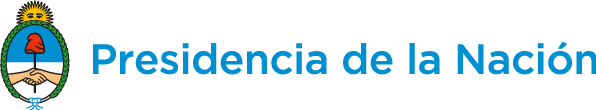

In [225]:
soup

In [ ]:
header = soup.findAll('th')

In [ ]:
try:
    # Encabezado --> Obtengo las fechas
    df_table = pd.DataFrame()
    header = soup.findAll('th')
    dates = []
    for cell in header[2:]:
        date = datetime.strptime(cell.find(text=True), '%d/%m/%y').date()
        dates.append(date)
    df_table['date'] = dates
    # Temperaturas:
    rows = soup.find(string=re.compile('GBA')).parent.parent.contents
    idx = 0
    temps = []
    for row in rows[4:]:
        # OJO: hay líneas donde se setea el tipo de letra y color con un \n de texto, por eso pregunto strip()!=''
        if row.name =='td' and row.string.strip() != '':
            temp = row.string.replace('\xa0°', '')
            temps.append(float(temp))
            idx+=1
    df_table['temp'] = temps
    columns=['MetroGAS', 'Naturgy BAN', 'Camuzzi Gas Pampeana', 'Camuzzi Gas del Sur', 'Distribuidora de Gas Cuyana'
            , 'Distribuidora de Gas del Centro', 'Litoral Gas', 'Gasnor', 'GasNea']
    for column in columns:
        rows = soup.find('td', string=re.compile(column)).parent.children #contents
        idx = 0
        rows_x_df = []
        for row in rows:
            # OJO: hay líneas donde se setea el tipo de letra y color con un \n de texto, por eso pregunto strip()!=''
            if row.name =='td' and row.string.strip() != column and row.string.strip() != '':
                rows_x_df.append(float(row.string))
                idx+=1
        df_table[column] = rows_x_df
    df_table.rename(columns={'MetroGAS': 'metrogas', 'Naturgy BAN': 'naturgyban'
                       , 'Camuzzi Gas Pampeana': 'camuzzi_pamp', 'Camuzzi Gas del Sur': 'camuzzi_sur'
                       , 'Distribuidora de Gas Cuyana': 'dist_cuyo'
                       , 'Distribuidora de Gas del Centro': 'dist_centro', 'Litoral Gas': 'litoral'
                       , 'Gasnor': 'gasnor', 'GasNea': 'gasnea'}, inplace=True)

except Exception as err:
    formatted_lines = traceback.format_exc().splitlines()
    txt = formatted_lines[1] + '\n' + formatted_lines[-1]
    if write_log:
        logging.error('Error Retrieving Table Data ' + '\n' + txt)
        raise OSError('Error Retrieving Table Data ' + '\n' + txt)
    else:
        print('Error Retrieving Table Data ' + '\n' + txt)
if write_log:
    logging.info('[2] Table Data Retrieved OK.')
df_table

,date,temp,metrogas,naturgyban,camuzzi_pamp,camuzzi_sur,dist_cuyo,dist_centro,litoral,gasnor,gasnea
0,2022-06-23,7.700,15.570,14.730,16.684,20.033,6.737,6.877,6.630,2.050,1.079
1,2022-06-24,9.500,15.827,14.700,16.722,20.553,6.862,6.750,6.600,1.950,1.075
2,2022-06-25,7.500,14.842,14.760,15.881,19.485,6.649,6.602,6.100,1.980,1.080
3,2022-06-26,9.000,13.592,13.830,14.860,18.192,6.171,6.694,5.800,1.800,1.027
4,2022-06-27,10.000,15.941,15.070,16.101,19.786,6.268,6.931,6.100,2.090,1.074


# PRUEBA con excel (requiere recibir por mail el excel)

In [97]:
def check_format(df, doc):
    bool_raise = False
    error_txt = ''
    try:
        if type(df.loc[report_date_row][report_date_col]) != datetime:
            bool_raise = True
            error_txt = 'Error Retrieving Data From Excel ' + doc + '\n' + 'Incorrect Format - Report Date is not a Datetime' +\
                ' Row: ' + str(report_date_row) + ' Col: ' + report_date_col
        if type(df.loc[fechas_row][fechas_col]) != datetime:
            bool_raise = True
            error_txt = 'Error Retrieving Data From Excel ' + doc + '\n' + 'Incorrect Format - Encabe Dates is not Datetime' +\
                ' Row: ' + str(fechas_row) + ' Col: ' + fechas_col
        for key in dict_segmentos_in_rows:
            if key not in df.loc[dict_segmentos_in_rows[key]][segmentos_col]:
                bool_raise = True
                error_txt = 'Error Retrieving Data From Excel ' + doc + '\n' + \
                    'Incorrect Format - Details Demanda Dentro Sist Transporte '+ key + ' ' + str(dict_segmentos_in_rows[key])
                break
    except Exception as err:
        formatted_lines = traceback.format_exc().splitlines()
        txt = formatted_lines[1] + '\n' + formatted_lines[-1]
        bool_raise = True
        error_txt = 'Error Retrieving Data From Excel ' + doc + '\n' + 'Incorrect Format' + '\n' + txt
    return bool_raise, error_txt


In [117]:
def get_tramo_1(df):
    bool_raise = False
    error_txt = ''
    df_dem_proy = pd.DataFrame()
    df_dem_real = pd.DataFrame()
    try:
        #### tramo 1 del reporte:
        #### Dataset de Demanda Dentro y Fuera del sistema PROYECTADA
        lst_dem_proy = []
        #### Dataset de Demanda Dentro y Fuera del sistema REAL
        lst_dem_real = []
        #### identificar las columnas con datos
        for column in df_.columns:
            if type(df_.loc[fechas_row][column]) == datetime:
                fecha = df_.loc[fechas_row][column]
                idx = 0
                for key in dict_segmentos_in_rows:
                    lst_dem_proy.append([fecha, 'dentro_sist_transporte', segmento_demanda_in[idx]
                                        , df_.loc[dict_segmentos_in_rows[key]][column]])
                    idx +=1
                idx = 0
                for key in dict_segmentos_out_rows:
                    lst_dem_proy.append([fecha, 'fuera_sist_transporte', segmento_demanda_out[idx]
                                        , df_.loc[dict_segmentos_out_rows[key]][column]])
                    idx +=1
            elif df_.loc[fechas_row][column] == 'REAL':
                # La fecha es la procesada en el loop justo anterior --> se usa
                idx = 0
                for key in dict_segmentos_in_rows:
                    lst_dem_real.append([fecha, 'dentro_sist_transporte', segmento_demanda_in[idx]
                                            , df_.loc[dict_segmentos_in_rows[key]][column]])
                    idx +=1
                idx = 0
                for key in dict_segmentos_out_rows:
                    lst_dem_real.append([fecha, 'fuera_sist_transporte', segmento_demanda_out[idx]
                                            , df_.loc[dict_segmentos_out_rows[key]][column]])
                    idx +=1
        df_dem_proy = pd.DataFrame(data=lst_dem_proy, columns=['fecha', 'in_out_sist_transporte', 'segmento', 'demanda_estimada'])
        df_dem_real = pd.DataFrame(data=lst_dem_real, columns=['fecha', 'in_out_sist_transporte', 'segmento', 'demanda_real'])
    except Exception as err:
        formatted_lines = traceback.format_exc().splitlines()
        txt = formatted_lines[1] + '\n' + formatted_lines[-1]
        bool_raise = True
        error_txt = 'Error Retrieving Data From Excel ' + doc + '\n' + 'Tramo 1' + '\n' + txt
    return df_dem_proy, df_dem_real, bool_raise, error_txt

## Data Load From Excel
The excel File should be in data_path folder.


In [112]:
## Seteos de ubicaciones - 2022-07-01:
report_date_row = 2
report_date_col = 'G'
fechas_row = 3
fechas_col = 'J'
segmentos_col = 'F'
dict_segmentos_in_rows ={'Demanda Prioritaria': 9, 'Ajuste de Demanda': 10, 'Gas Combustible': 11, 'GNC': 12, 'Industria': 13
                  , 'Usinas': 14, 'GNL BB': 15, 'TGN': 16, 'TGS': 17}
segmento_demanda_in = ['prioritaria', 'ajuste', 'gas_combustible', 'gnc', 'industrias', 'usinas', 'gnl_bb', 'expo_tgn', 'expo_tgs']
dict_segmentos_out_rows ={'Tierra del Fuego': 20, 'Usinas en Boca Pozo': 21, 'Gas Pac': 22, 'Mega': 23, 'Refinor': 24
                  , 'Atacama': 25, 'Methanex': 26}
segmento_demanda_out = ['tf', 'usinas_bp', 'gas_pacifico', 'mega', 'refinor', 'gas_atacama', 'methanex']

In [120]:
try:
    doc = os.path.join(data_path, '06 - 27 jun al 03 jul 28 jun 18 hs.xlsx')
    doc = os.path.join(data_path, '06 - 27 jun al 03 jul 27 jun 18 hs.xlsx')
    df_ = pd.read_excel(os.path.join(doc))
    # Se renombran las columnas para mejor manejo, imitando al Excel:
    cols = [a for a in string.ascii_uppercase[:df_.shape[1]]]
    if df_.shape[1] > 26:
        cols.extend(['A'+ a for a in string.ascii_uppercase[:df_.shape[1]-26]])
    df_.columns = cols
    # Las 3 primeras columnas vienen vacías --> drop
    df_.drop(df_.columns[0:3], axis=1, inplace=True)
    # Chequeo del formato general del excel, para evitar avanzar si cambiaron el formato
    bool_raise, error_txt = check_format(df_, doc)
    if bool_raise:
        if write_log:
            logging.error(error_txt)
            raise OSError(error_txt)
        else:
            print(error_txt)
    # Fecha del reporte:
    report_date = df_.loc[2][report_date_col]      
    df_dem_proy, df_dem_real, bool_raise, error_txt = get_tramo_1(df_)
    if bool_raise:
        if write_log:
            logging.error(error_txt)
            raise OSError(error_txt)
        else:
            print(error_txt)
    # Hay filas sin datos --> se eliminan.
    #df_.drop(df_.index[[0,1, 2]], inplace=True)
except Exception as err:
    formatted_lines = traceback.format_exc().splitlines()
    txt = formatted_lines[1] + '\n' + formatted_lines[-1]
    if write_log:
        logging.error('Error Retrieving Data From Excel ' + doc + '\n' + txt)
        raise OSError('Error Retrieving Data From Excel ' + doc + ' ' + txt)
    else:
        print('Error Retrieving Data From Excel ' + doc + ' ' + txt)
if write_log:
    logging.info('[1] Data Retrieved From Excel ' + doc + ' Ok.')
df_
df_dem_real

,fecha,in_out_sist_transporte,segmento,demanda_real
0,2022-06-24,dentro_sist_transporte,prioritaria,88.3
1,2022-06-24,dentro_sist_transporte,ajuste,2.2
2,2022-06-24,dentro_sist_transporte,gas_combustible,4.9
3,2022-06-24,dentro_sist_transporte,gnc,7.2
4,2022-06-24,dentro_sist_transporte,industrias,33.7
5,2022-06-24,dentro_sist_transporte,usinas,15.1
6,2022-06-24,dentro_sist_transporte,gnl_bb,0.0
7,2022-06-24,dentro_sist_transporte,expo_tgn,2.5
8,2022-06-24,dentro_sist_transporte,expo_tgs,0.5
9,2022-06-24,fuera_sist_transporte,tf,2.6


In [10]:
pdf = os.path.join(data_path, 'PS_20220701.pdf')
# https://github.com/tabulapdf/tabula-java/wiki/Using-the-command-line-tabula-extractor-tool#grab-coordinates-of-the-table-you-want
df_pdf = tabula.read_pdf(pdf, area=[20,0,800,900], stream=True) #, pandas_options={'skiprows':0})
print(df_pdf[0].shape)
df_pdf[0].head()

'pages' argument isn't specified.Will extract only from page 1 by default.


(50, 9)


,Unnamed: 0,OPERACIÓN GASODUCTOS TGN + TGS,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,FECHA: vie 01 - jul 18 hs,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,PROYECCION SEMANA: 27 de jun al 03 jul'22,jue 30 - jun,NaN,REAL,vie 01 - jul,sáb 02 - jul,dom 03 - jul,lun 04 - jul
2,NaN,Temperatura Media Estimada Anillo Bs.As. °C,12.5,NaN,12.4,11.0,11.5,11.0,12.5
3,NaN,DEMANDA TOTAL MMm3,163.0,NaN,162.5,170.2,164.1,158.6,174.5
4,NaN,A- DENTRO DE SISTEMAS DE TRANSPORTE,145.8,NaN,146.2,152.9,147.2,141.8,157.5


In [8]:
pdf = os.path.join(data_path, 'PS_20220630.pdf')
# https://github.com/tabulapdf/tabula-java/wiki/Using-the-command-line-tabula-extractor-tool#grab-coordinates-of-the-table-you-want
df_pdf = tabula.read_pdf(pdf, area=[20,0,800,900], stream=True) #, pandas_options={'skiprows':0})
df_pdf[0]

'pages' argument isn't specified.Will extract only from page 1 by default.


,Unnamed: 0,OPERACIÓN GASODUCTOS TGN + TGS,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,FECHA: jue 30 - jun 18 hs,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,PROYECCION SEMANA: 27 de jun al 03 jul'22,mié 29 - jun,REAL,jue 30 - jun,vie 01 - jul,NaN,sáb 02 - jul,dom 03 - jul
2,NaN,Temperatura Media Estimada Anillo Bs.As. °C,13.5,13.7,12.5,NaN,11.00,11.5,9.5
3,NaN,DEMANDA TOTAL MMm3,156.9,156.5,163.0,NaN,169.20,160.1,160.3
4,NaN,A- DENTRO DE SISTEMAS DE TRANSPORTE,140.0,140.0,145.8,NaN,151.90,142.9,143.1
5,NaN,Demanda Prioritaria (R+SGP),75.5,73.7,75.6,NaN,75.10,73.2,73.2
6,NaN,Ajuste de Demanda (conforme a proyecciones del...,3.3,3.0,1.7,NaN,1.90,0.6,2.0
7,NaN,Gas Combustible,4.6,4.8,4.5,NaN,4.90,4.7,4.8
8,NaN,GNC,6.4,6.5,6.9,NaN,7.30,6.9,6.0
9,Saldo,Industria (P3+GU+Grandes C.),31.8,33.1,33.3,NaN,35.80,35.0,34.8


In [ ]:
df_load = pd.read_csv(path_data + '\\' + file, sep=';', encoding='latin-1', index_col=0, header=0)
df_diario.timestamp = pd.to_datetime(df_diario.timestamp, format='%Y-%m-%d')
print(df_diario.shape)
df_diario.head(5)

In [ ]:
##### TRAMO 2
#origen_inyeccion_col = 'A'
#origen_inyeccion_nac_rows = {'Sur': 25, 'Neuba I': 26, 'Neuba II': 27, 'Patagónico': 28, 'Norte': 30, 'Neuquén': 31}
#origen_inyeccion_ext_rows = {'Bolivia': 32, 'Chile': 33, 'PEAK SHAVING': 34, 'BUQUE ESCOBAR': 35, 'BUQUE BAHIA BLANCA': 36
                           #, 'PIPA': 37}
def get_tramo_2(df):
    bool_raise = False
    error_txt = ''
    df_iny_proy = pd.DataFrame()
    df_iny_real = pd.DataFrame()
    try:
        #### tramo 2 del reporte:
        #### Dataset de Inyección transportistas nacionales PROYECTADA
        lst_iny_proy = []
        #### Dataset de Inyección origen exterior (importaciones) REAL
        lst_iny_real = []
        #### identificar las columnas con datos
        for column in df.columns:
            if type(df.loc[fechas_row][column]) == str:
                fecha = re.findall(r'\w{3} \d{2} - \w{3}', df_pdf.loc[fechas_row][column])
                if fecha:
                    fecha = fecha[0] + ' ' + str(datetime.today().year)
                    bool_raise, error_txt, fecha = convert_date(fecha)
                    if bool_raise:
                        return bool_raise, ' Tramo 1 - ' + error_txt
                    fecha_ant = fecha
                    idx = 0
                    for key in origen_inyeccion_nac_rows:
                        lst_iny_proy.append([fecha, 'nacional', origen_inyeccion_nac[idx]
                                            , df.loc[origen_inyeccion_nac_rows[key]][column]])
                        idx +=1
                    idx = 0
                    for key in origen_inyeccion_ext_rows:
                        lst_iny_proy.append([fecha, 'importado', origen_inyeccion_ext[idx]
                                            , df.loc[origen_inyeccion_ext_rows[key]][column]])
                        idx +=1
                elif df.loc[fechas_row][column] == 'REAL':
                    # La fecha es la procesada en el loop justo anterior --> se usa
                    idx = 0
                    for key in origen_inyeccion_nac_rows:
                        lst_iny_real.append([fecha_ant, 'nacional', origen_inyeccion_nac[idx]
                                            , df.loc[origen_inyeccion_nac_rows[key]][column]])
                        idx +=1
                    idx = 0
                    for key in origen_inyeccion_ext_rows:
                        lst_iny_real.append([fecha_ant, 'importado', origen_inyeccion_ext[idx]
                                            , df.loc[origen_inyeccion_ext_rows[key]][column]])
                        idx +=1
        df_iny_proy = pd.DataFrame(data=lst_iny_proy, columns=['fecha', 'nacional_importada', 'origen', 'iny_estimada'])
        df_iny_real = pd.DataFrame(data=lst_iny_real, columns=['fecha', 'nacional_importada', 'origen', 'iny_real'])
    except Exception as err:
        formatted_lines = traceback.format_exc().splitlines()
        txt = formatted_lines[1] + '\n' + formatted_lines[-1]
        bool_raise = True
        error_txt = 'Error Retrieving Data From Excel ' + doc + '\n' + 'Tramo 2' + '\n' + txt
    return bool_raise, error_txt, df_iny_proy, df_iny_real